[*********************100%%**********************]  1 of 1 completed


2023-11-09 20:31:59.411980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 20:31:59.412349: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
74/74 - 2s - loss: 0.0017 - 2s/epoch - 25ms/step
Epoch 2/50
74/74 - 1s - loss: 2.3557e-05 - 981ms/epoch - 13ms/step
Epoch 3/50
74/74 - 1s - loss: 2.1161e-05 - 1s/epoch - 14ms/step
Epoch 4/50
74/74 - 1s - loss: 2.2283e-05 - 1s/epoch - 14ms/step
Epoch 5/50
74/74 - 1s - loss: 1.9812e-05 - 1s/epoch - 14ms/step
Epoch 6/50
74/74 - 1s - loss: 2.0947e-05 - 1s/epoch - 14ms/step
Epoch 7/50
74/74 - 1s - loss: 2.0620e-05 - 971ms/epoch - 13ms/step
Epoch 8/50
74/74 - 1s - loss: 2.1503e-05 - 1s/epoch - 14ms/step
Epoch 9/50
74/74 - 1s - loss: 2.0854e-05 - 984ms/epoch - 13ms/step
Epoch 10/50
74/74 - 1s - loss: 1.9985e-05 - 1s/epoch - 14ms/step
Epoch 11/50
74/74 - 1s - loss: 2.1369e-05 - 988ms/epoch - 13ms/step
Epoch 12/50
74/74 - 1s - loss: 1.9695e-05 - 971ms/epoch - 13ms/step
Epoch 13/50
74/74 - 1s - loss: 2.0292e-05 - 987ms/epoch - 13ms/step
Epoch 14/50
74/74 - 1s - loss: 2.0872e-05 - 971ms/epoch - 13ms/step
Epoch 15/50
74/74 - 1s - loss: 1.9801e-05 - 970ms/epoch - 13ms/step
Epoch 16/50
74

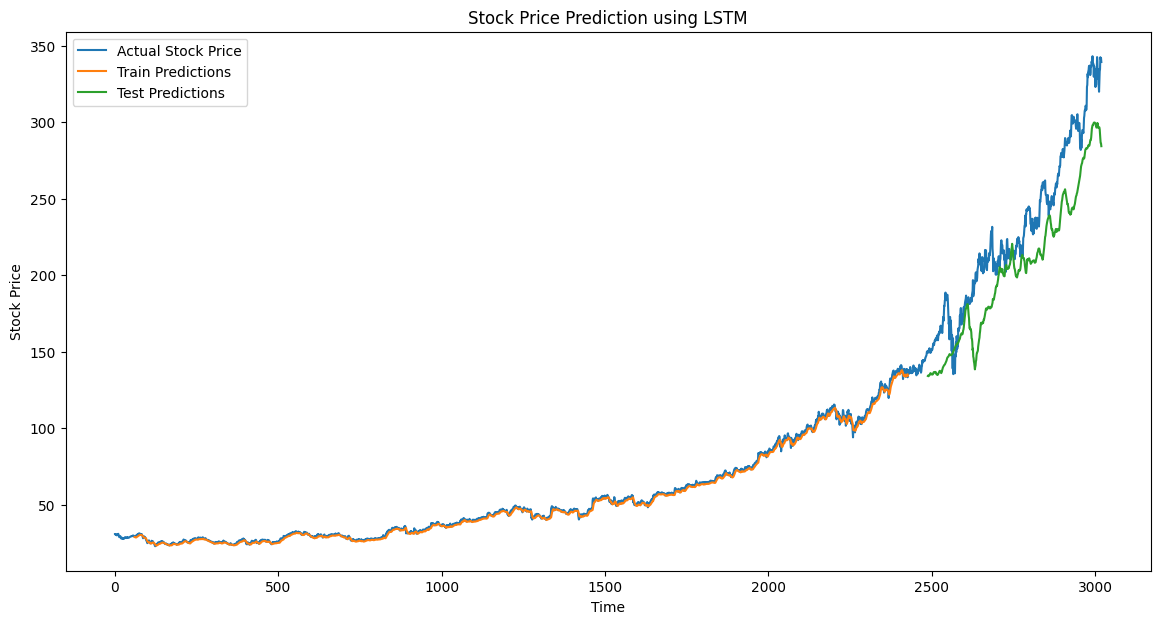

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def prepare_lstm_data(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:(i+n_steps), 0])
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

np.random.seed(42)

ticker = 'MSFT'
start_date = '2010-01-01'
end_date = '2021-12-31'
n_steps = 60  
epochs = 50
batch_size = 32

stock_data = download_stock_data(ticker, start_date, end_date)

data = stock_data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

X, y = prepare_lstm_data(data_scaled, n_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

train_plot = np.empty_like(data_scaled)
train_plot[:, :] = np.nan
train_plot[n_steps:len(train_predict) + n_steps, :] = train_predict

test_plot = np.empty_like(data_scaled)
test_plot[:, :] = np.nan

start_index = len(train_predict) + (n_steps * 2)
end_index = start_index + len(test_predict)

if end_index <= len(data_scaled):
    test_plot[start_index:end_index, :] = test_predict
else:
    test_plot[start_index:, :] = test_predict[:len(data_scaled) - start_index, :]


plt.figure(figsize=(14, 7))
plt.plot(scaler.inverse_transform(data_scaled), label='Actual Stock Price')
plt.plot(train_plot, label='Train Predictions')
plt.plot(test_plot, label='Test Predictions')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
